In [4]:
from pymer4.simulate import simulate_lmm, simulate_lm
from pymer4.utils import get_resource_path, _sig_stars
import os
import pandas as pd
import numpy as np
from pymer4.models import Lm, Lmer, Lm2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
sns.set_context('notebook');
sns.set_style("whitegrid")
from scipy.stats import ttest_1samp
import warnings
warnings.filterwarnings("ignore")
os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline

# Single example

In [251]:
num_obs_grp = 50
num_grps = 50
num_coef = 3
formula = 'DV ~ IV1 + IV2 + IV3'
data, blups, betas = simulate_lmm(num_obs_grp, num_coef, num_grps)

In [252]:
data.mean()

DV        0.790709
IV1      -0.000656
IV2      -0.022323
IV3      -0.016429
Group    25.500000
dtype: float64

In [253]:
blups.mean()

Intercept    0.776017
IV1          0.482068
IV2          0.677721
IV3          0.108141
dtype: float64

In [254]:
print(f"True betas: {betas}")

True betas: [0.7531433  0.47652723 0.7553581  0.10079037]


In [255]:
# Fit lmer
lmer = Lmer(formula + '+ (IV1 + IV2 + IV3 | Group)',data=data)
lmer.fit(summarize=False)
lmer.coefs
print(f"Absolute Error of Coef Recovery: {diffs(betas, lmer.coefs['Estimate'])}")
print(f"Sum of Model Standard Errors: {lmer.coefs['SE'].sum()}")
print(f"Sum of Model T statistics: {lmer.coefs['T-stat'].abs().sum()}")

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.807507,0.720874,0.894140,0.044201,48.883311,18.268830,1.745697e-23,***
IV1,0.510778,0.422115,0.599441,0.045237,47.430395,11.291166,4.849310e-15,***
IV2,0.680483,0.597597,0.763369,0.042289,50.615658,16.091106,1.520424e-21,***
IV3,0.132141,0.053716,0.210566,0.040014,48.671442,3.302400,1.801418e-03,**


Absolute Error of Coef Recovery: 0.1948401978126452
Sum of Model Standard Errors: 0.17174123576555847
Sum of Model T statistics: 48.95350153221572


In [257]:
# Fit lmer with random-intercepts only
lmer_mis = Lmer(formula + '+ (1 | Group)',data=data)
lmer_mis.fit(summarize=False)
lmer_mis.coefs
print(f"Absolute Error of Coef Recovery: {diffs(betas, lmer_mis.coefs['Estimate'])}")
print(f"Sum of Model Standard Errors: {lmer_mis.coefs['SE'].sum()}")
print(f"Sum of Model T statistics: {lmer_mis.coefs['T-stat'].abs().sum()}")

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.808882,0.717628,0.900135,0.046559,48.979598,17.373343,1.398782e-22,***
IV1,0.504312,0.461621,0.547004,0.021782,2467.272994,23.152955,1.752511e-107,***
IV2,0.686206,0.642071,0.730341,0.022518,2466.466218,30.473201,2.212212e-173,***
IV3,0.153608,0.110409,0.196808,0.022041,2468.883967,6.969224,4.073517e-12,***


Absolute Error of Coef Recovery: 0.20549306002577458
Sum of Model Standard Errors: 0.11289982634952181
Sum of Model T statistics: 77.96872294622804


In [260]:
# Fit two-stage OLS
lm2 = Lm2(formula,data=data,group='Group')
lm2.fit(summarize=False)
lm2.coefs
print(f"Absolute Error of Coef Recovery: {diffs(betas, lm2.coefs['Estimate'])}")
print(f"Sum of Model Standard Errors: {lm2.coefs['SE'].sum()}")
print(f"Sum of Model T statistics: {lm2.coefs['T-stat'].abs().sum()}")

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.807740,0.721203,0.894276,0.043062,49,18.757583,0.000000e+00,***
IV1,0.517129,0.425126,0.609133,0.045783,49,11.295329,3.108624e-15,***
IV2,0.676295,0.592783,0.759807,0.041557,49,16.273911,0.000000e+00,***
IV3,0.122822,0.041169,0.204476,0.040632,49,3.022793,3.976494e-03,**


Absolute Error of Coef Recovery: 0.19629355573777932
Sum of Model Standard Errors: 0.17103367419027482
Sum of Model T statistics: 49.34961664707694


In [262]:
# Finally fit clustered errors LM
lm = Lm(formula,data=data)
lm.fit(robust='cluster',cluster='Group',summarize=False)
lm.coefs
print(f"Absolute Error of Coef Recovery: {diffs(betas, lm.coefs['Estimate'])}")
print(f"Sum of Model Standard Errors: {lm.coefs['SE'].sum()}")
print(f"Sum of Model T statistics: {lm.coefs['T-stat'].abs().sum()}")

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
Intercept,0.809068,0.714968,0.903169,0.046749,46,17.306754,0.000000e+00,***
IV1,0.497186,0.406172,0.588199,0.045215,46,10.995967,1.820766e-14,***
IV2,0.690244,0.597362,0.783126,0.046143,46,14.958665,0.000000e+00,***
IV3,0.159771,0.077771,0.241771,0.040737,46,3.921988,2.906246e-04,***


Absolute Error of Coef Recovery: 0.20067824006065368
Sum of Model Standard Errors: 0.17884469457930047
Sum of Model T statistics: 47.18337423314602


## Simulate Parameter Grid

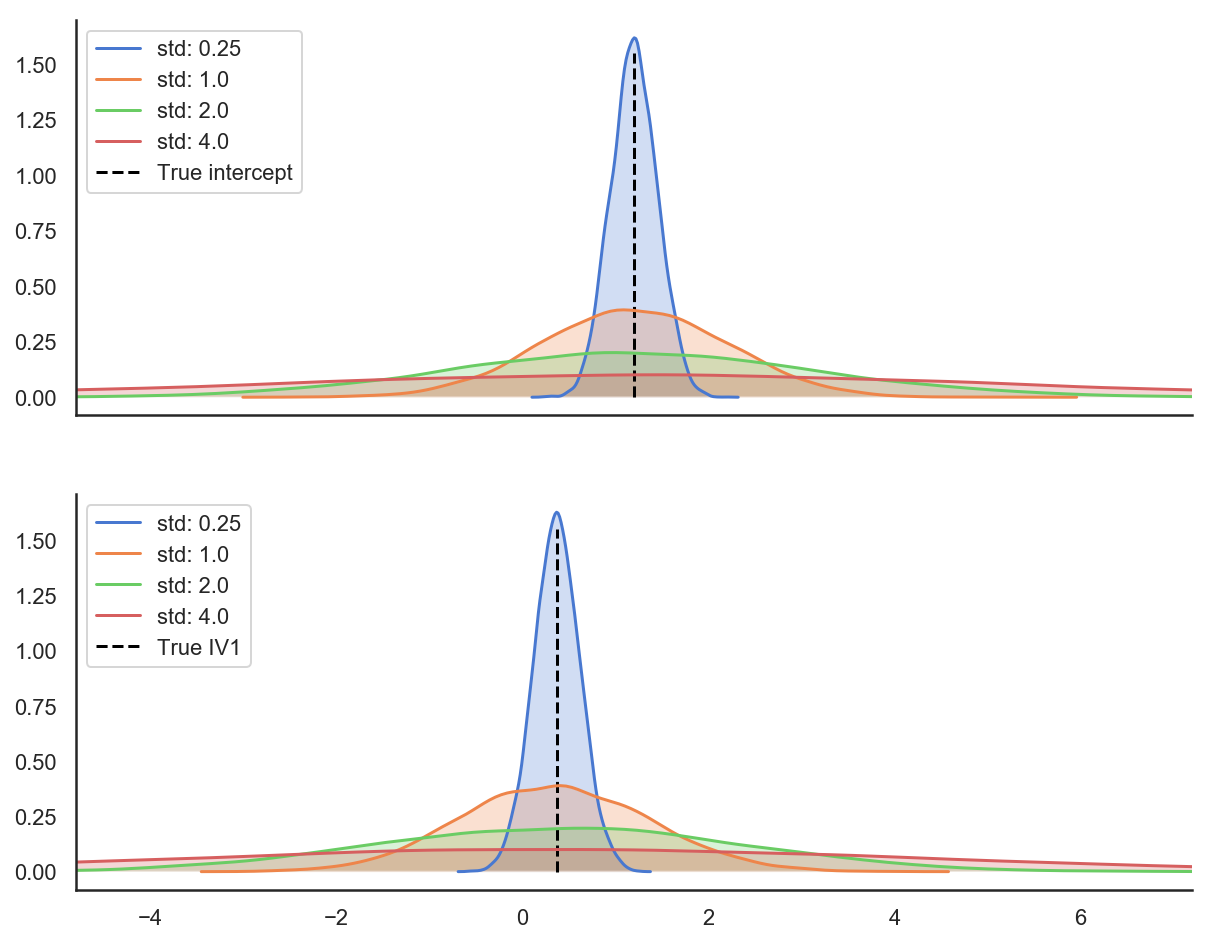

In [5]:
all_blups = pd.read_csv('./clustered_blups_comparison_100_5.csv')
coef_vals=[1.2,.37] 
sns.set_style('white');
sns.set_palette(sns.color_palette('muted'))
f,ax = plt.subplots(2,1,figsize=(10,8),sharex=True)
a = all_blups.query("Sigma == .25")
b = all_blups.query("Sigma == 1.")
c = all_blups.query("Sigma == 2.")
d = all_blups.query("Sigma == 4.")
scale = 5

# Intercept
clip = (coef_vals[0]-coef_vals[0]*scale,
        coef_vals[0]+coef_vals[0]*scale)
sns.kdeplot(a['Intercept'],shade=True,label='std: 0.25',ax=ax[0])
sns.kdeplot(b['Intercept'],shade=True,label='std: 1.0',ax=ax[0])
sns.kdeplot(c['Intercept'],shade=True,label='std: 2.0',ax=ax[0])
sns.kdeplot(d['Intercept'],shade=True,label='std: 4.0',ax=ax[0])
ax[0].vlines(x=coef_vals[0],ymin=0,ymax=1.55,linestyles='--',
          color='k',label='True intercept')
ax[0].set(xlim=clip)
ax[0].legend(loc='upper left');

# IV1
clip = (coef_vals[1]-coef_vals[1]*scale,
        coef_vals[1]+coef_vals[1]*scale)
sns.kdeplot(a['IV1'],shade=True,label='std: 0.25',ax=ax[1])
sns.kdeplot(b['IV1'],shade=True,label='std: 1.0',ax=ax[1])
sns.kdeplot(c['IV1'],shade=True,label='std: 2.0',ax=ax[1])
sns.kdeplot(d['IV1'],shade=True,label='std: 4.0',ax=ax[1])
ax[1].vlines(x=coef_vals[1],ymin=0,ymax=1.55,linestyles='--',
          color='k',label='True IV1')
ax[1].legend(loc='upper left');

sns.despine();

In [2]:
def diffs(a, b):
    """Absolute error"""
    return np.sum(np.abs(a - b))

def calc_model_err(model_type, formula, betas, data):
    """
    Fit a model type to data using pymer4. Return the absolute error of the model's 
    coefficients, the sum of the model's standard errors, and the sum of the model's
    t-statistics. Also log if the model failed to converge in the case of lme4. 
    """
    
    if model_type == 'lm':
        model = Lm(formula, data=data)
        model.fit(robust='cluster',cluster='Group',summarize=False)
    elif model_type == 'lmer':
        model = Lmer(formula + '+ (IV1 + IV2 + IV3 | Group)',data=data)
        model.fit(summarize=False, no_warnings=True)
    elif model_type == 'lmer_mis':
        model = Lmer(formula + '+ (1 | Group)',data=data)
        model.fit(summarize=False, no_warnings=True)
    elif model_type == 'lm2':
        model = Lm2(formula,data=data,group='Group')
        model.fit(n_jobs = 2, summarize=False)
        
    coef_diffs = diffs(betas, model.coefs['Estimate'])
    model_ses = model.coefs['SE'].sum()
    model_ts = model.coefs['T-stat'].abs().sum()
    if (model.warnings is None) or (model.warnings == []):
        model_success = True
    else:
        model_success = False
    
    return coef_diffs, model_ses, model_ts, model_success, model.coefs

def save_results(err_params, sim_params, sim, model_type, model_coefs, df, coef_df, save=True):
    
    """Aggregate and save results using pandas"""
    
    model_coefs['Sim'] = sim
    model_coefs['Model'] = model_type
    model_coefs['Num_grp'] = sim_params[0]
    model_coefs['Num_obs_grp'] = sim_params[1]
    model_coefs['Btwn_grp_sigma'] = sim_params[2]
    
    coef_df = coef_df.append(model_coefs)
    
    dat = pd.DataFrame({
            'Model': model_type,
            'Num_grp': sim_params[0],
            'Num_obs_grp': sim_params[1],
            'Btwn_grp_sigma': sim_params[2],
            'Coef_abs_err': err_params[0],
            'SE_sum': err_params[1],
            'T_sum': err_params[2],
            'Fit_success': err_params[3],
            'Sim': sim
        },  index = [0])
    
    df = df.append(dat,ignore_index=True)
    if save:
        df.to_csv('./sim_results2.csv',index=False)
        coef_df.to_csv('./sim_estimates2.csv')
    return df, coef_df


In [3]:
nsim = 50 # Number of simulations per model
num_grps = [5, 25, 100] # Number of "clusters"
obs_grp = [5, 25, 100] # Number of observations per "cluster"
grp_sigmas = [.1, .25, 1., 2., 4.] # Between cluster variance
num_coef = 3 # Number of terms in the regression equation
noise_params = (0, 1) # Assume each cluster has normally distributed noise
seed = 0 # to repeat this analysis
formula = 'DV ~ IV1 + IV2 + IV3' # The model formula

In [4]:
results = pd.DataFrame()
coef_df = pd.DataFrame()
models = ['lm', 'lm2', 'lmer', 'lmer_mis']
for N in num_grps:
    for O in obs_grp:
        for S in grp_sigmas:
            for I in range(nsim):
                data, blups, betas = simulate_lmm(O, num_coef, N, grp_sigmas=S, noise_params=noise_params)
                for M in models:
                    c, s, t, success, coefs, = calc_model_err(M, formula, betas, data)
                    results, coef_df = save_results([c,s,t, success], [N,O,S], I, M, coefs, results, coef_df)

In [5]:
results = pd.read_csv('./sim_results2.csv')

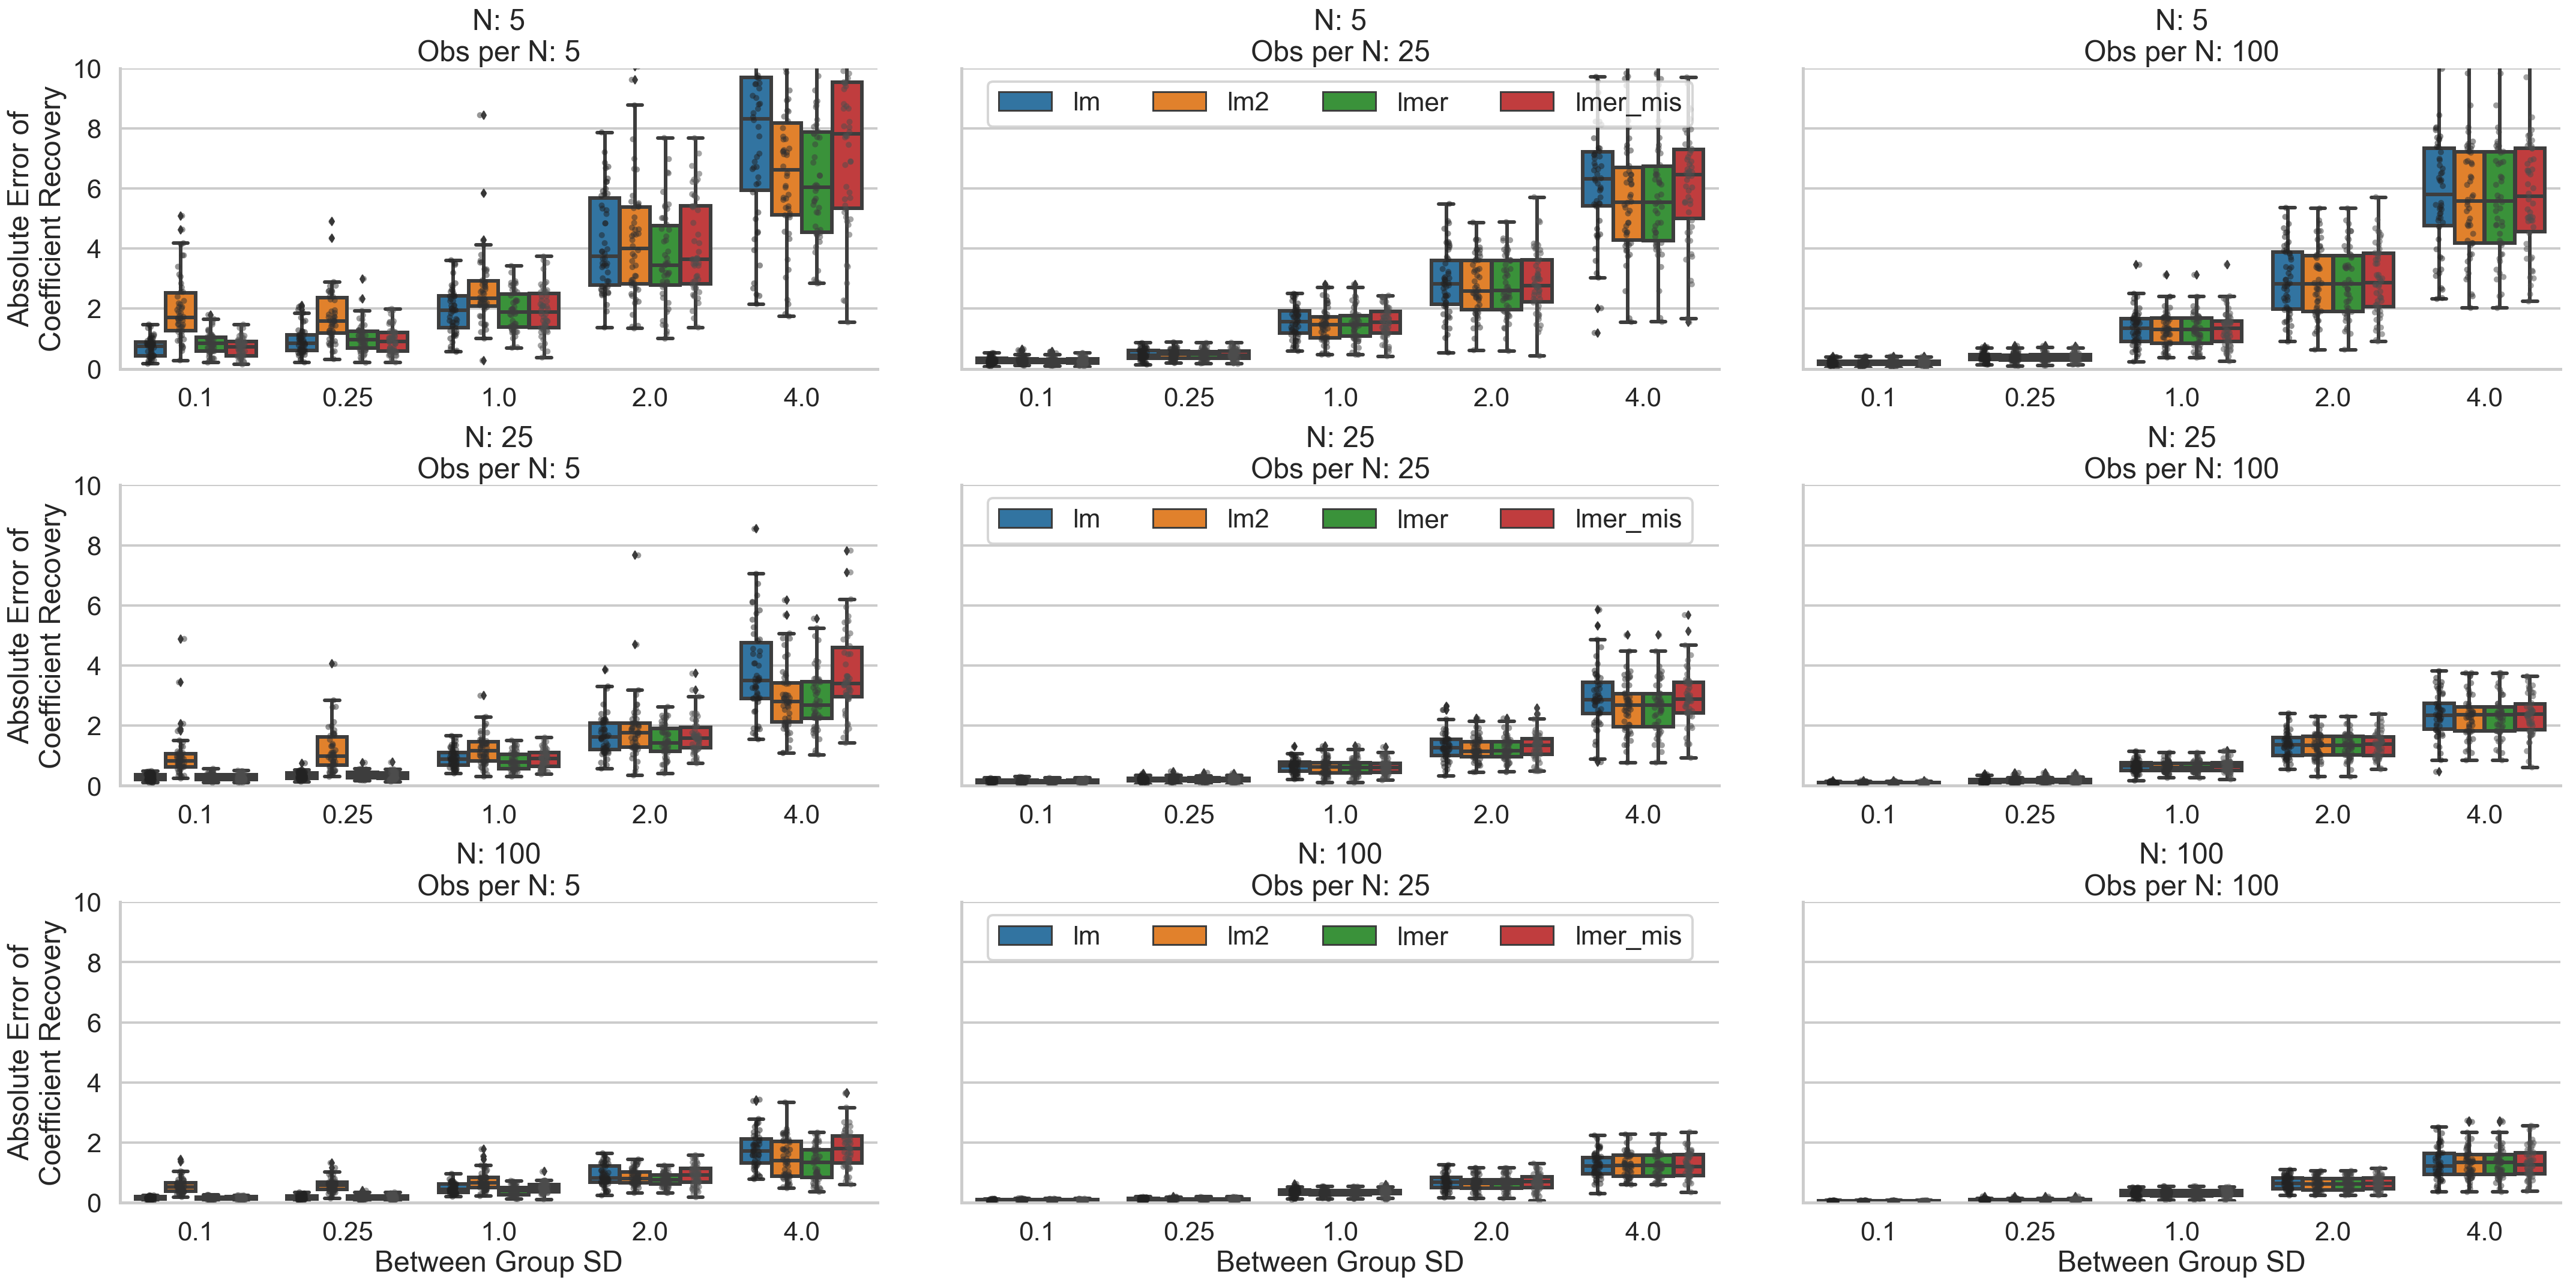

In [10]:
f, axes = plt.subplots(3,3,sharey=True,figsize=(30,15))
for i, (ax, (n,grp)) in enumerate(zip(axes.flat,results.groupby(['Num_grp', 'Num_obs_grp']))):
    ax = sns.boxplot(x='Btwn_grp_sigma',y='Coef_abs_err',hue='Model',data=grp,ax=ax);
    ax = sns.stripplot(x='Btwn_grp_sigma',y='Coef_abs_err',hue='Model',jitter=True,split=True,color='.3', alpha=.5,hue_order=results['Model'].unique(),data=grp,ax=ax);
    ylim = ax.get_ylim();
    _=ax.set(ylim=[0,10], title=f"N: {n[0]}\nObs per N: {n[1]}", ylabel='Absolute Error of\nCoefficient Recovery', xlabel='Between Group SD');
    handles, labels = ax.get_legend_handles_labels();
    _=ax.legend(handles[:4],labels[:4],loc='upper center', ncol=4);
    if i in [1,2,4,5,7,8]:
        _ = ax.set(ylabel='')
    if i in range(0,6):
        _ = ax.set(xlabel='')
    if i in [0,2,3,5,6,8]:
        ax.get_legend().remove()
    sns.despine();
plt.tight_layout();

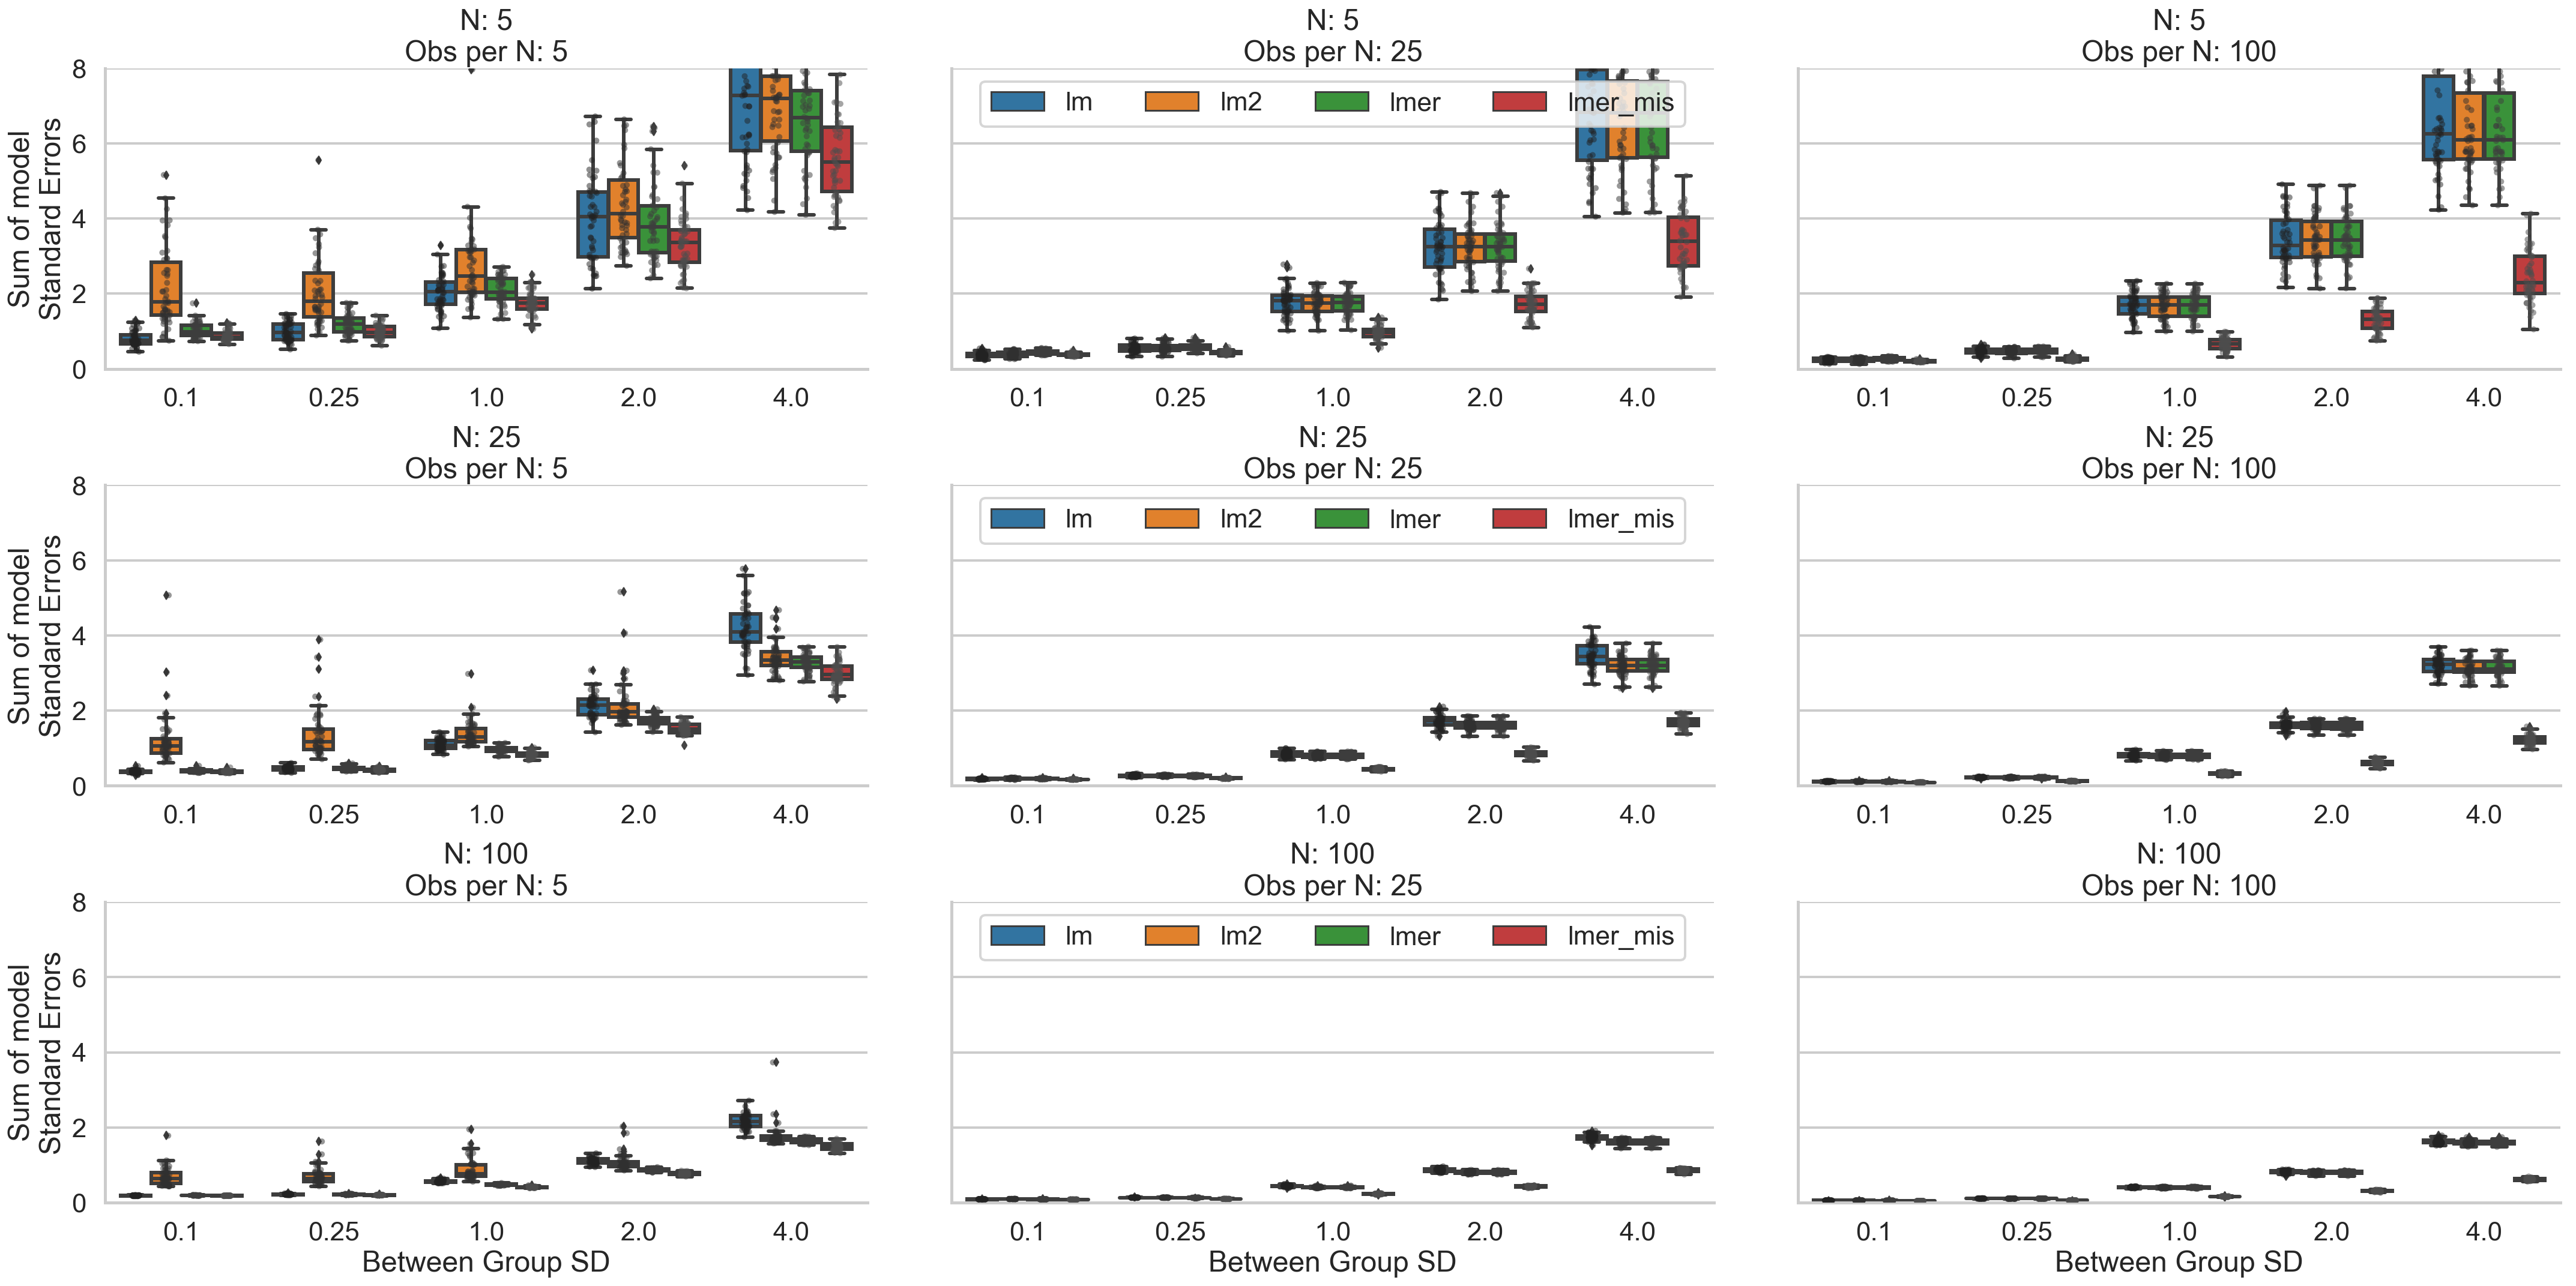

In [6]:
f, axes = plt.subplots(3,3,sharey=True,figsize=(30,15))
for i, (ax, (n,grp)) in enumerate(zip(axes.flat,results.groupby(['Num_grp', 'Num_obs_grp']))):
    ax = sns.boxplot(x='Btwn_grp_sigma',y='SE_sum',hue='Model',data=grp,ax=ax);
    ax = sns.stripplot(x='Btwn_grp_sigma',y='SE_sum',hue='Model',jitter=True,split=True,color='.3', alpha=.5,hue_order=results['Model'].unique(),data=grp,ax=ax);
    ylim = ax.get_ylim();
    _=ax.set(ylim=[0,8],title=f"N: {n[0]}\nObs per N: {n[1]}", ylabel='Sum of model\nStandard Errors', xlabel='Between Group SD');
    if i in [1,2,4,5,7,8]:
        _ = ax.set(ylabel='')
    if i in range(0,6):
        _ = ax.set(xlabel='')
    handles, labels = ax.get_legend_handles_labels();
    _=ax.legend(handles[:4],labels[:4], loc='upper center', ncol=4);
    if i in [0,2,3,5,6,8]:
        ax.get_legend().remove()
    sns.despine();
plt.tight_layout();

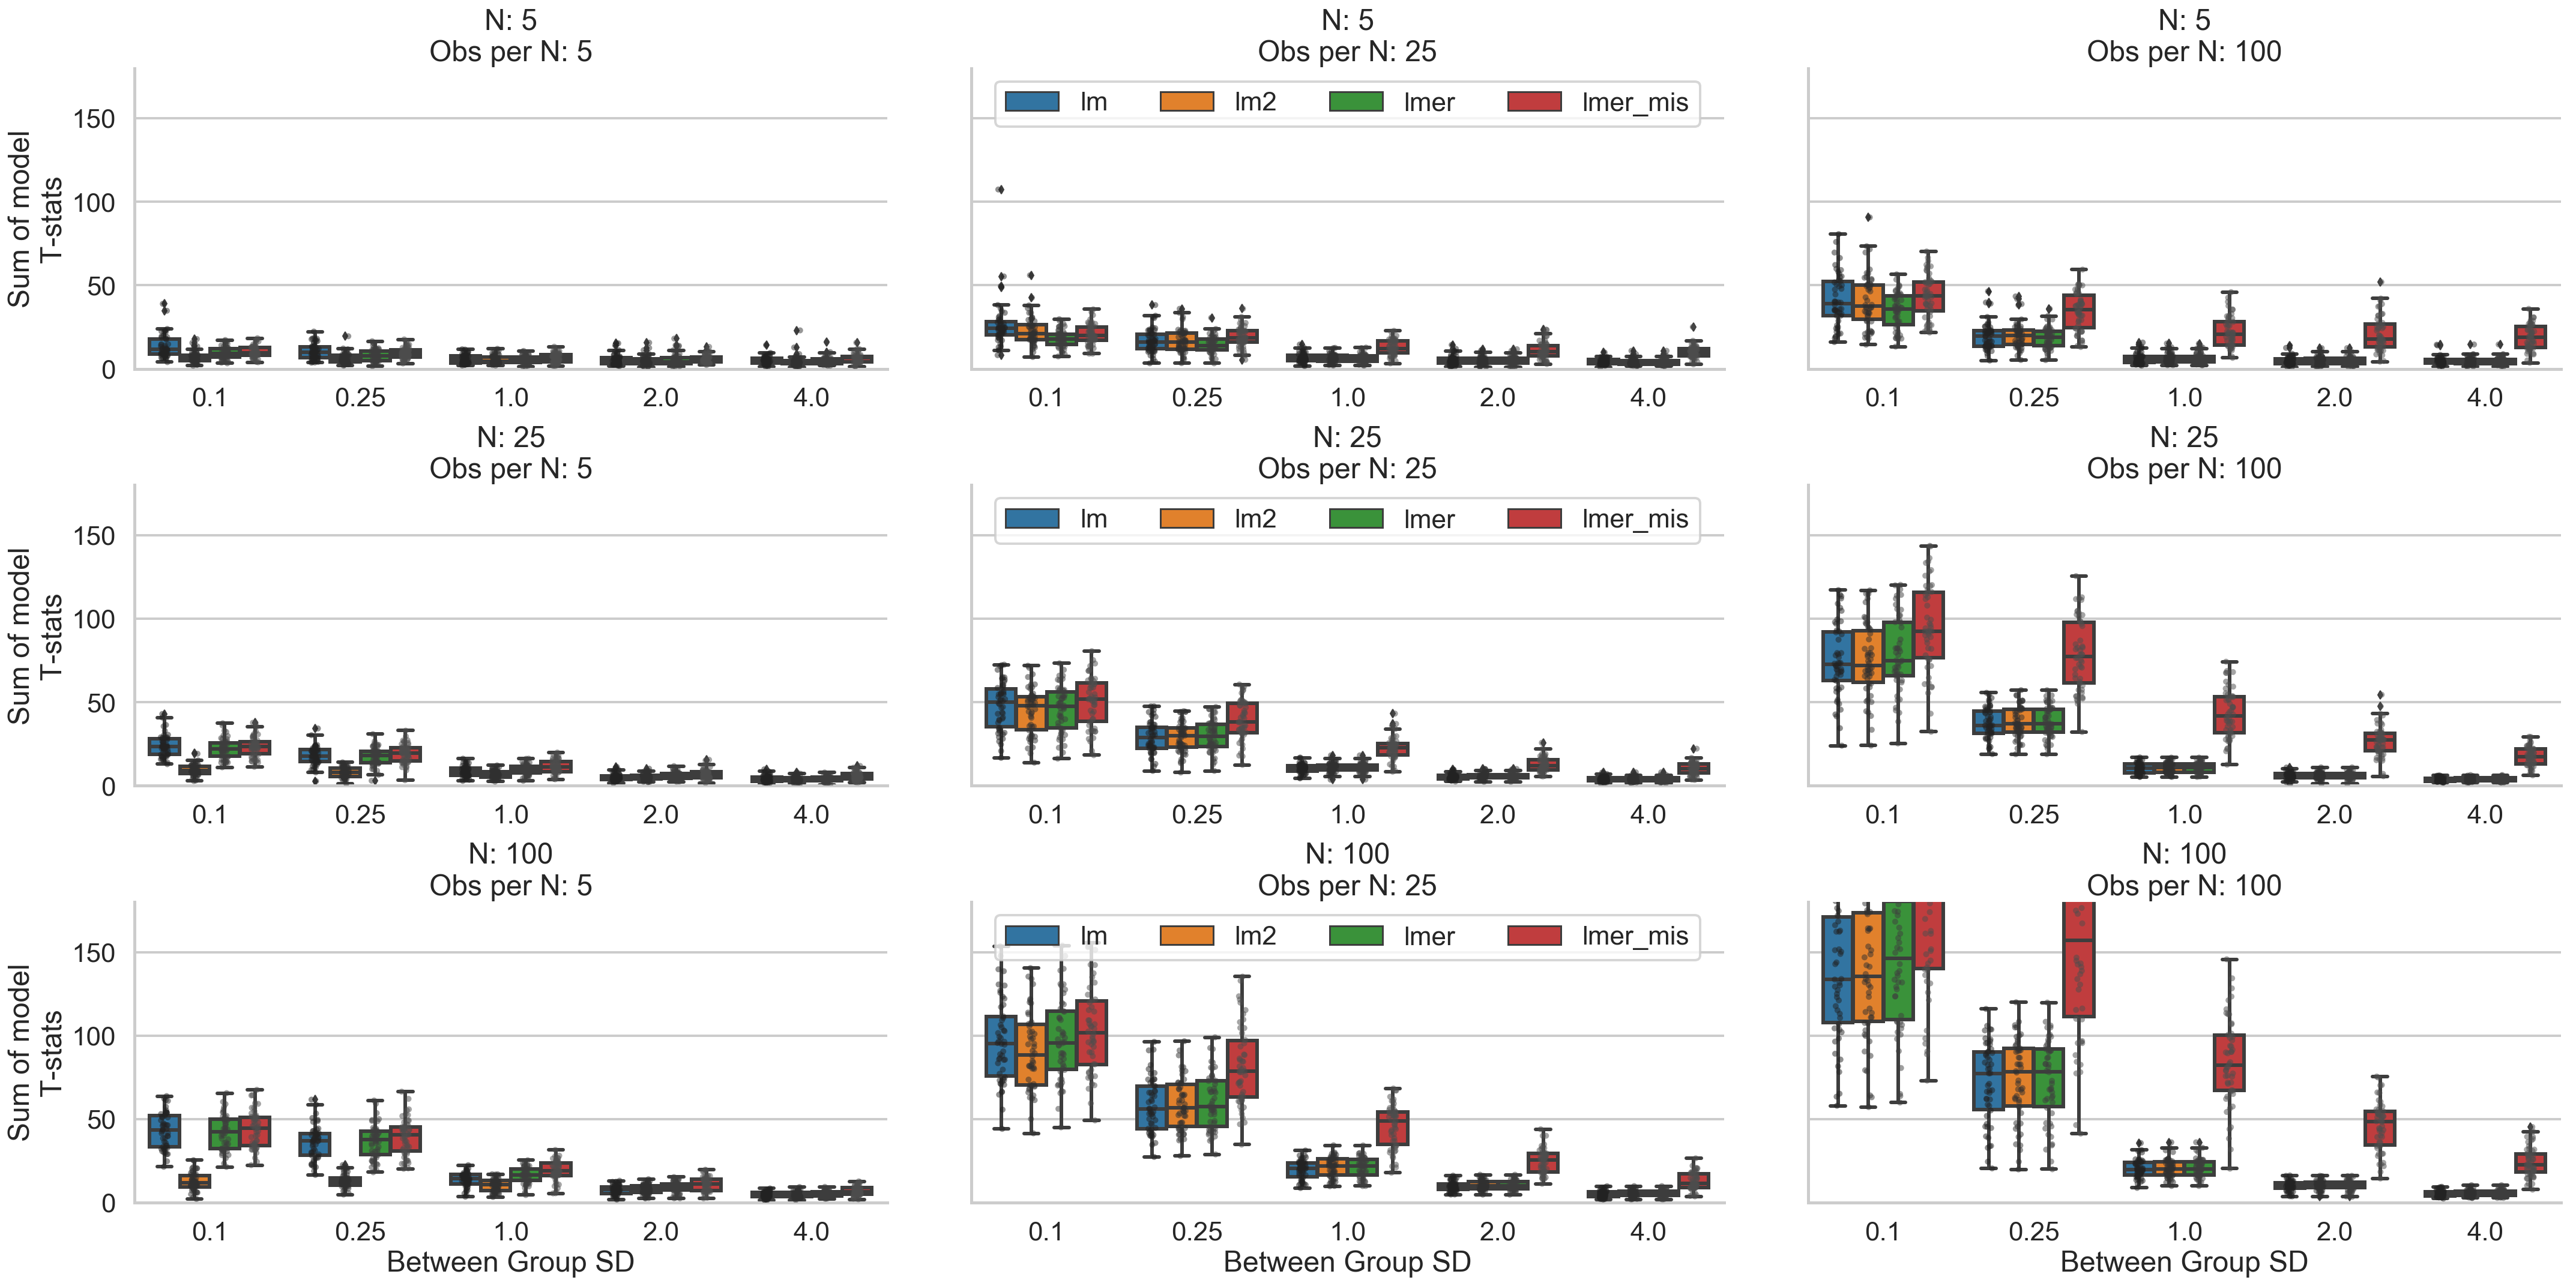

In [7]:
f, axes = plt.subplots(3,3,sharey=True,figsize=(30,15))
for i, (ax, (n,grp)) in enumerate(zip(axes.flat,results.groupby(['Num_grp', 'Num_obs_grp']))):
    ax = sns.boxplot(x='Btwn_grp_sigma',y='T_sum',hue='Model',data=grp,ax=ax);
    ax = sns.stripplot(x='Btwn_grp_sigma',y='T_sum',hue='Model',jitter=True,split=True,color='.3', alpha=.5,hue_order=results['Model'].unique(),data=grp,ax=ax);
    ylim = ax.get_ylim();
    _=ax.set(ylim=[0,180],title=f"N: {n[0]}\nObs per N: {n[1]}", ylabel='Sum of model\nT-stats', xlabel='Between Group SD');
    handles, labels = ax.get_legend_handles_labels();
    _=ax.legend(handles[:4],labels[:4], loc='upper center', ncol=4);
    if i in [1,2,4,5,7,8]:
        _ = ax.set(ylabel='')
    if i in range(0,6):
        _ = ax.set(xlabel='')
    if i in [0,2,3,5,6,8]:
        ax.get_legend().remove()
    sns.despine();
plt.tight_layout();

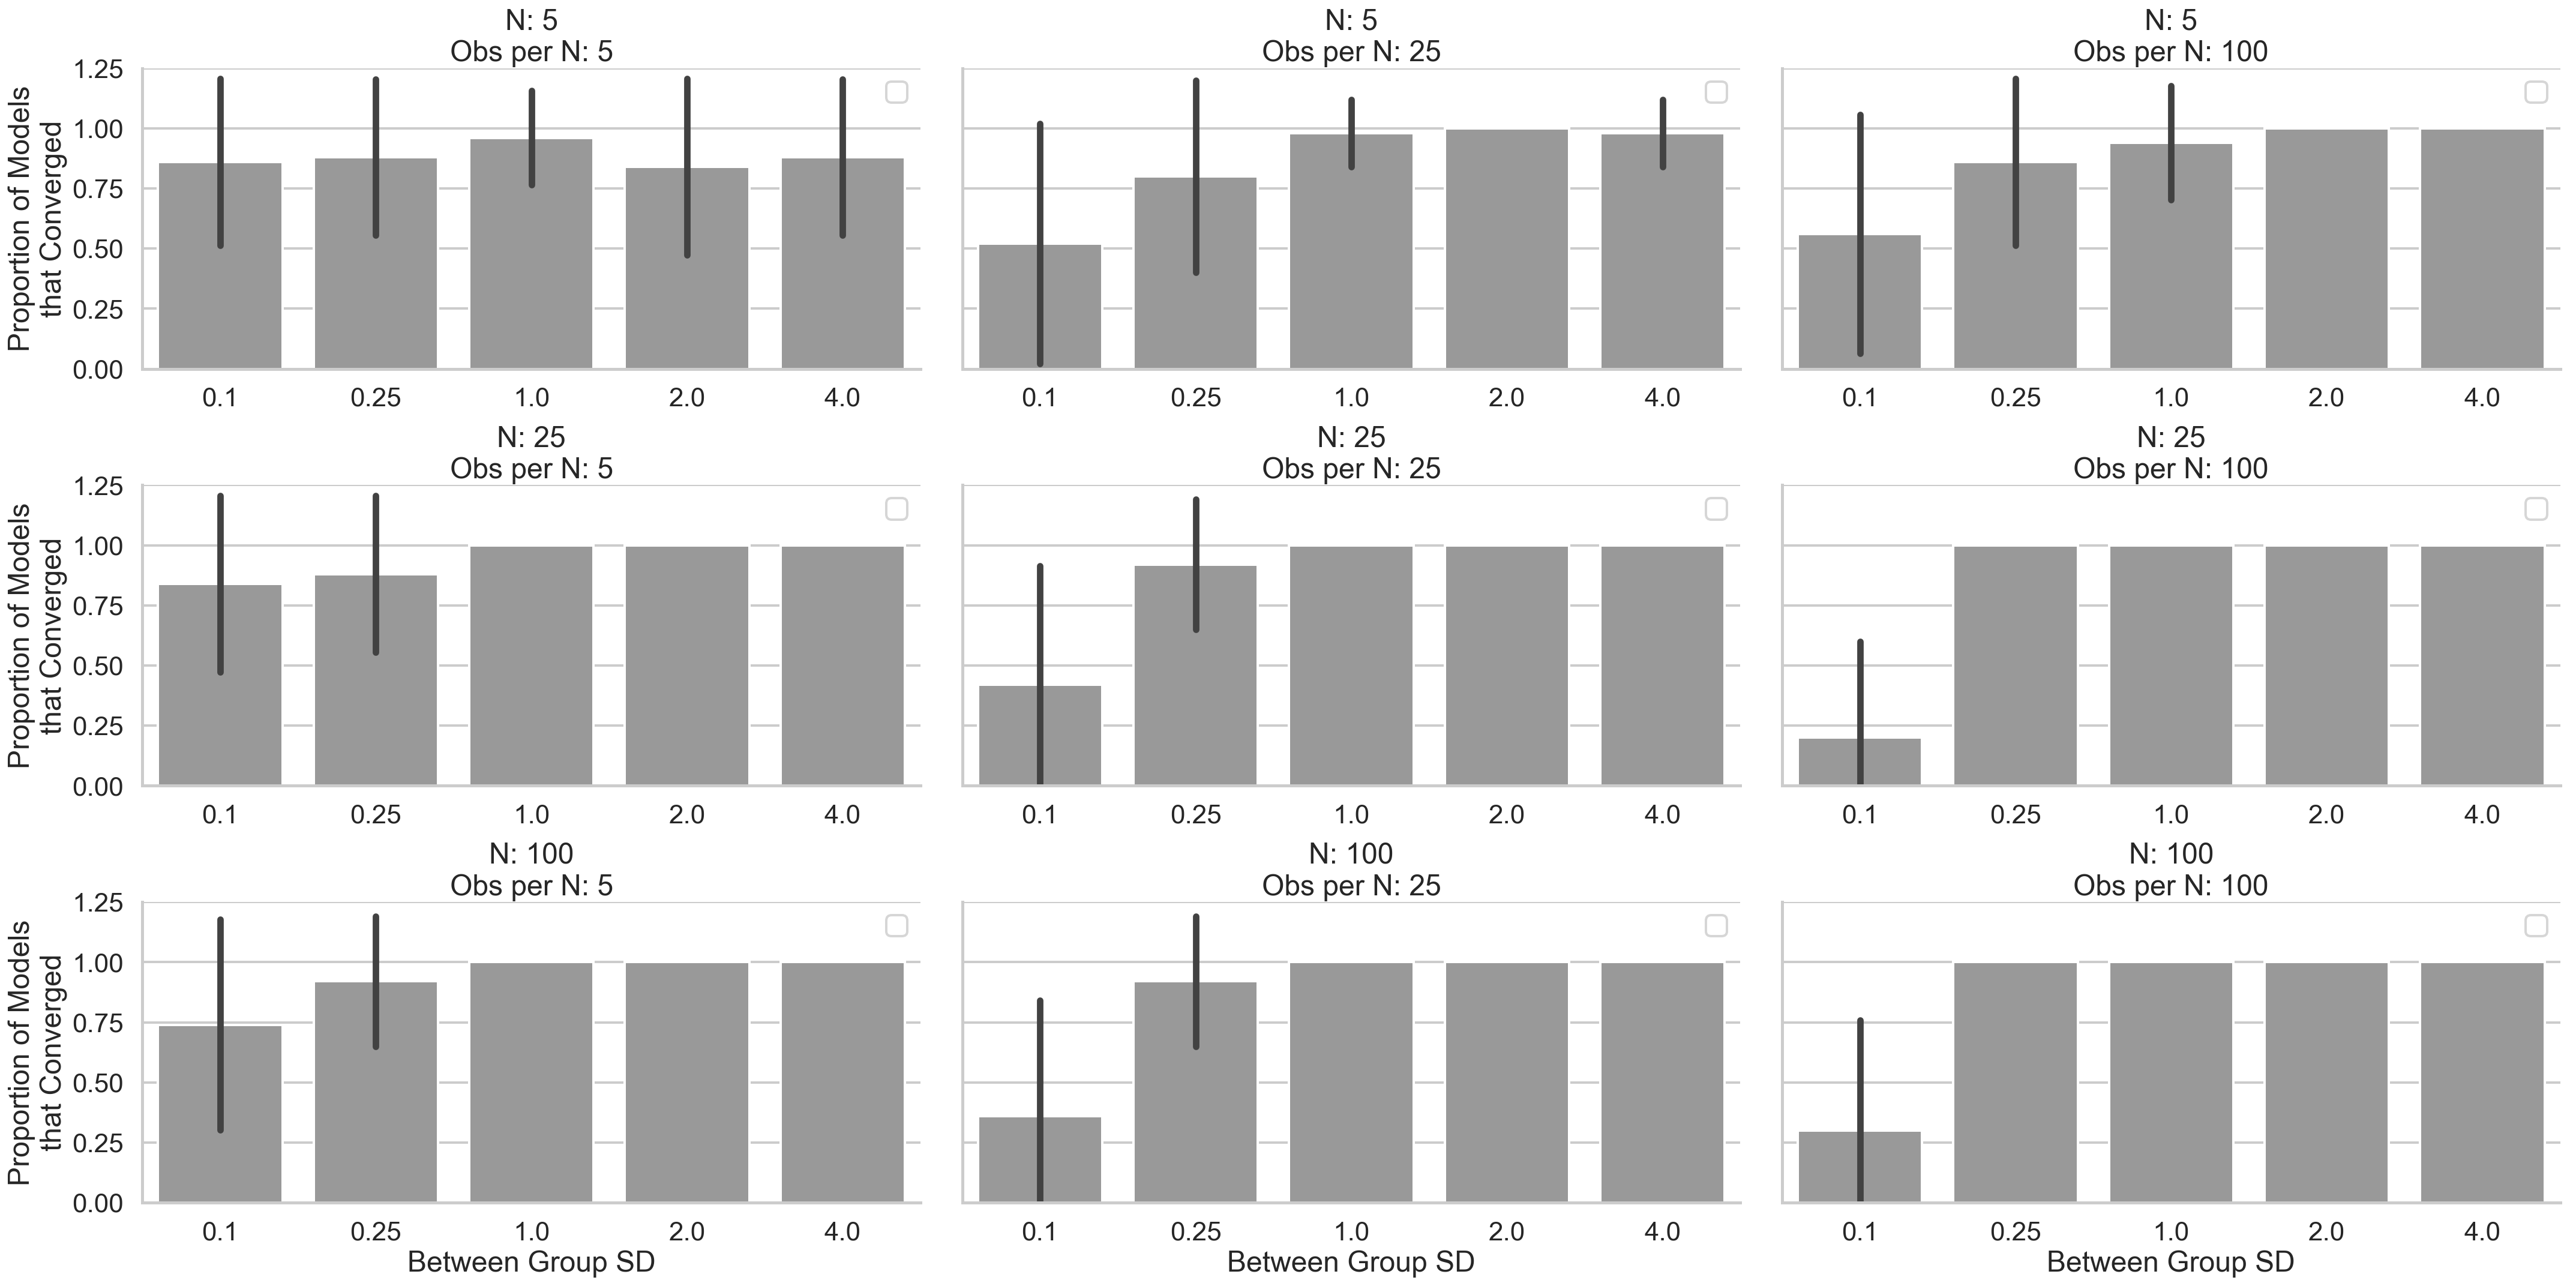

In [11]:
f, axes = plt.subplots(3,3,sharey=True,figsize=(30,15))
for i, (ax, (n,grp)) in enumerate(zip(axes.flat,results.query("Model == 'lmer'").groupby(['Num_grp', 'Num_obs_grp']))):
    ax = sns.barplot(x='Btwn_grp_sigma',y='Fit_success',color='.6',ci='sd',data=grp,ax=ax);
    ylim = ax.get_ylim();
    _=ax.set(ylim=[0,1.25],title=f"N: {n[0]}\nObs per N: {n[1]}", ylabel='Proportion of Models\nthat Converged', xlabel='Between Group SD');
    handles, labels = ax.get_legend_handles_labels();
    _=ax.legend(handles[4:],labels[4:]);
    if i in [1,2,4,5,7,8]:
        _ = ax.set(ylabel='')
    if i in range(0,6):
        _ = ax.set(xlabel='')
    sns.despine();
plt.tight_layout();